In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint

# Data Processing

## Hudson Bay Data 

In [ ]:
lynx_hare_dat = pd.read_csv("data/Leigh1968_harelynx.csv")
lynx_hare_dat.set_index('year', inplace=True)
lynx_hare_dat

,year,hare,lynx
0,1847,21000,49000
1,1848,12000,21000
2,1849,24000,9000
3,1850,50000,7000
4,1851,80000,5000
5,1852,80000,5000
6,1853,90000,11000
7,1854,69000,22000
8,1855,80000,33000
9,1856,93000,33000


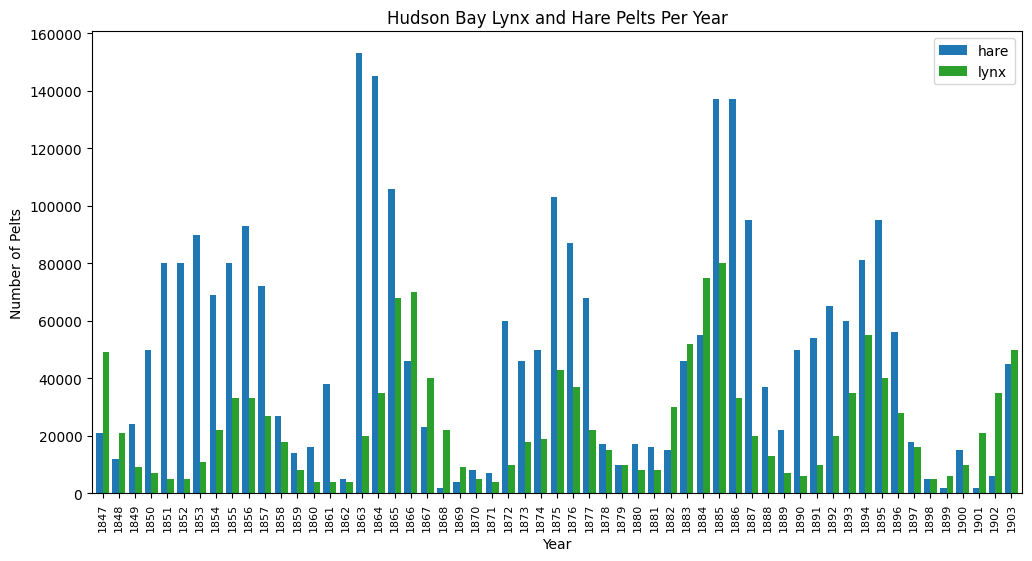

In [22]:
colors = ["#1f77b4", "#2ca02c"]
lynx_hare_dat.plot(kind="bar", color = colors, width = 0.8, figsize=(12,6))
plt.title("Hudson Bay Lynx and Hare Pelts Per Year")
plt.ylabel("Number of Pelts")
plt.xlabel("Year")
plt.xticks(rotation=90, fontsize=8)
plt.show()


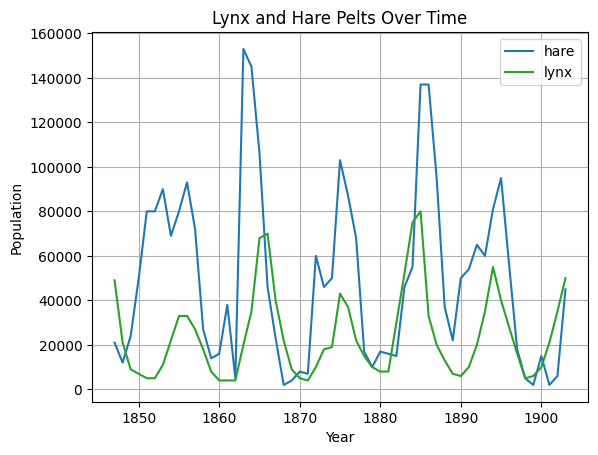

In [20]:
ax = plt.gca()
lynx_hare_dat.plot( y = "hare", ax = ax, color = "#1f77b4")
lynx_hare_dat.plot( y = "lynx", ax = ax, color = "#2ca02c")
ax.grid(True)
ax.set_xlabel("Year")
ax.set_ylabel("Population")
ax.set_title("Lynx and Hare Pelts Over Time")
ax.legend()

## Generate Synthetic Data for Predator Prey System

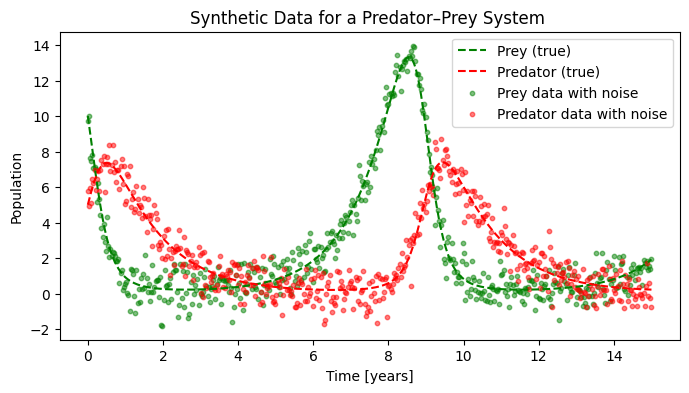

In [ ]:
# True parameters
alpha_true = 1.0   # Prey growth rate
beta_true  = 0.5   # Predation rate
delta_true = 0.25  # Predator growth per prey eaten
gamma_true = 0.8   # Predator death rate

def lotka_volterra(t, y):
    x, y_pred = y  # x = prey, y_pred = predator
    dxdt = alpha_true * x - beta_true * x * y_pred
    dydt = delta_true * x * y_pred - gamma_true * y_pred
    return [dxdt, dydt]

# Initial conditions
x0 = 10.0
y0 = 5.0
y_init = [x0, y0]

# Time points
t_start, t_end = 0.0, 15.0
t_eval = np.linspace(t_start, t_end, 500)

# Solve the true system
sol = solve_ivp(lotka_volterra, [t_start, t_end], y_init, t_eval=t_eval)
prey_true = sol.y[0, :]
pred_true = sol.y[1, :]

# Add noise to simulate experimental data
noise_level = 0.75
prey_noisy = prey_true + noise_level*np.random.randn(len(prey_true))
pred_noisy = pred_true + noise_level*np.random.randn(len(pred_true))

# Convert Data to Pytorch Tensors
t_train = torch.tensor(t_eval, dtype=torch.float32)
prey_train = torch.tensor(prey_noisy, dtype=torch.float32)
pred_train = torch.tensor(pred_noisy, dtype=torch.float32)

y0_torch = torch.tensor([prey_noisy[0], pred_noisy[0]], dtype=torch.float32)



In [ ]:


# Plot
plt.figure(figsize=(8,4))
plt.plot(t_eval, prey_true, 'g--', label='Prey (true)')
plt.plot(t_eval, pred_true, 'r--', label='Predator (true)')
plt.scatter(t_eval, prey_noisy, color='green', s=10, alpha=0.5, label='Prey data with noise')
plt.scatter(t_eval, pred_noisy, color='red', s=10, alpha=0.5, label='Predator data with noise')
plt.xlabel('Time [years]')
plt.ylabel('Population')
plt.title('Synthetic Data for a Predator–Prey System ')
plt.legend()
plt.show()


# Defining the Neural Network

In [ ]:


class LotkaVolterraNN(nn.Module):
    """
    Neural network for learning unknown parts of predator-prey dynamics.
    Input: [prey, predator]
    Output: [dx unknown, dy unknown]
    """
    def __init__(self, input_dim=2, hidden_dim=16):
        super(LotkaVolterraNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 2)  # outputs dx_unknown, dy_unknown
        )

    def forward(self, t, u):
        return 0.05*torch.tanh(self.net(u))


# Defining the UDE class

In [ ]:
class LotkaVolterraUDE(nn.Module):
    def __init__(self, alpha, beta, delta, gamma, nn_model):
        super(LotkaVolterraUDE, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.delta = delta
        self.gamma = gamma
        self.nn_model = nn_model

    def forward(self, t, y):
        x, y_pred = y[..., 0], y[..., 1]
        u_cat = torch.stack([x, y_pred], dim=-1)
        nn_correction = self.nn_model(t, u_cat)  # shape (batch,2)
        nn_dx, nn_dy = nn_correction[..., 0], nn_correction[..., 1]

        dxdt = self.alpha * x - self.beta * x * y_pred + nn_dx
        dydt = self.delta * x * y_pred - self.gamma * y_pred + nn_dy

        return torch.stack([dxdt, dydt], dim=-1)


# Forward Simulation 

In [ ]:

def forward_sim(net_ode, y0, t_points):
    y0 = y0.unsqueeze(0)
    sol = odeint(net_ode, y0, t_points, method='rk4')
    return sol[:,0,:]


# Initiate NN and UDE

In [ ]:
hidden_dim = 32
lv_nn = LotkaVolterraNN(hidden_dim=hidden_dim)
lv_ude = LotkaVolterraUDE(alpha=alpha_true, beta=beta_true,
                      delta=delta_true, gamma=gamma_true,
                      nn_model=lv_nn)

optimizer = optim.Adam(lv_ude.parameters(), lr=5e-4)


# Training Loop

In [ ]:
num_epochs = 200
loss_history = []

for epoch in range(num_epochs):
    optimizer.zero_grad()
    sol_pred = forward_sim(lv_ude, y0_torch, t_train)
    prey_pred, pred_pred = sol_pred[:,0], sol_pred[:,1]
    loss = 0.5*torch.mean((prey_pred - prey_train)**2) + 0.5*torch.mean((pred_pred - pred_train)**2)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss={loss.item():.6f}")



Epoch 10, Loss=0.554034
Epoch 20, Loss=0.545794
Epoch 30, Loss=0.546968
Epoch 40, Loss=0.545735
Epoch 50, Loss=0.545272
Epoch 60, Loss=0.545132
Epoch 70, Loss=0.545138
Epoch 80, Loss=0.545124
Epoch 90, Loss=0.545117
Epoch 100, Loss=0.545107
Epoch 110, Loss=0.545099
Epoch 120, Loss=0.545092
Epoch 130, Loss=0.545084
Epoch 140, Loss=0.545075
Epoch 150, Loss=0.545067
Epoch 160, Loss=0.545058
Epoch 170, Loss=0.545049
Epoch 180, Loss=0.545040
Epoch 190, Loss=0.545031
Epoch 200, Loss=0.545021


# Evaluation

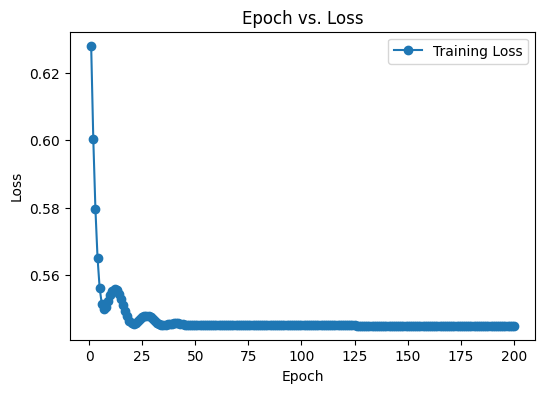

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(range(1, num_epochs+1), loss_history, marker='o', label='Training Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs. Loss")
plt.legend()
plt.show()


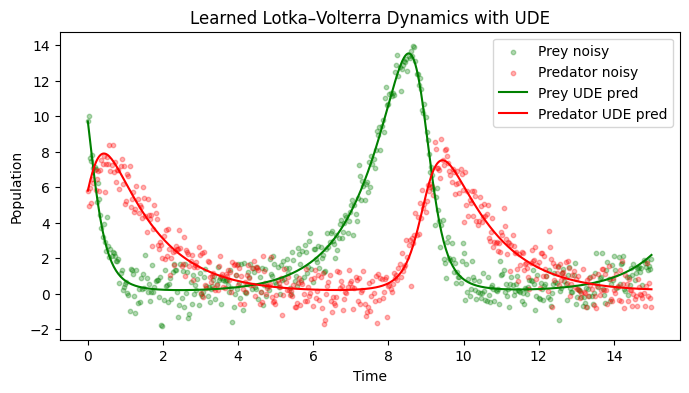

In [ ]:
sol_final = forward_sim(lv_ude, y0_torch, t_train).detach().numpy()
prey_final = sol_final[:,0]
pred_final = sol_final[:,1]

plt.figure(figsize=(8,4))
plt.scatter(t_eval, prey_noisy, color='green', s=10, alpha=0.3, label='Prey noisy')
plt.scatter(t_eval, pred_noisy, color='red', s=10, alpha=0.3, label='Predator noisy')
plt.plot(t_eval, prey_final, 'g-', label='Prey UDE pred')
plt.plot(t_eval, pred_final, 'r-', label='Predator UDE pred')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title(f'Learned Lotka–Volterra Dynamics with Noise Level = {noise_level}')
plt.legend()
plt.show()
